# Backtesting a Simple Pairs Trading Strategy

<sub>**by Aung Si**</sub><br>
<sub>April 28<sup>th</sup>, 2023</sub>

---

## Disclaimer
I am relatively new to quantitative analysis and the techniques presented in this report may not be comprehensive or fully optimized. The purpose of this analysis is to explore and learn about the concepts and techniques involved in pairs trading and cointegration, and not to provide investment advice or fully-vetted trading strategies. The results, interpretations, and conclusions drawn from this analysis should be taken with caution.*

---

## Introduction
In this paper, I backtest a pairs trading strategy based on the mean-reverting tendency of the spread between two securities. The assumption of mean reversion is founded on the historical cointegration of the pair, which implies a long-term equilibrium relationship between the two securities. By exploiting deviations from this equilibrium, the strategy seeks to generate profits while maintaining a market-neutral position.

#### Cointegration
Cointegration is a statistical concept used to describe the long-term relationship between two or more non-stationary time series. In the context of pairs trading, cointegration suggests that although the individual prices of the two securities may drift apart, there exists a stable, long-term relationship between them. This relationship implies that deviations from the equilibrium are temporary and that the spread between the two securities will eventually revert to its mean over time.

#### Exploiting the reversion
I use an in-sample dataset to test the cointegration of a basket of stock pairs based on the augmented Engle-Granger test. A pair that yields a p-value less than the specified significance level (0.05 in our case) is considered cointegrated. This pair is then assumed to be cointegrated throughout our out-of-sample data, and given their cointegration, we bet on the deviations from and the eventual reversion to the equilibrium.

To measure the deviation and reversion, I use a Z-score that represents the distance of a given datapoint from its mean. When the Z-score moves below 0 by 1 standard deviation, we enter a long position; that is, we long stock Y and short stock X. Once the Z-score returns to 0 (i.e. the spread between the pair has reverted to its mean), we exit the long; that is, we sell Y and repurchase X. Conversely, when the Z-score moves beyond 0 by 1 standard deviation, we enter a short position - short stock Y and long stock X. Once the Z-score returns to 0, we exit the long position - repurchase stock Y and sell stock X. The strategy is covered in more detail later.

#### Key Assumptions
1. Stocks that remain cointegrated in the in-sample dataset remain cointegrated in the out-of-sample dataset.
2. Total absence of transaction costs, fees, and tax (note that accounting for these can significantly hurt returns).
3. Returns are computed as if all the profits are reinvested.

---

## Finding Cointegrated Pairs

In [1]:
# Imports.
import quantfuncs as q
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd
import numpy as np
import random
import seaborn as sns

from statsmodels.regression.rolling import RollingOLS
from datetime import datetime
from itertools import combinations
from warnings import filterwarnings

filterwarnings('ignore')
q.mpl_cast('white')

From our universe of tickers and indices, I retrieve only the tickers and store them in the `universe` list.

In [2]:
# Displaying our universe of tickers and indices.
display(q.call_universe())

,Technology,Financial,Healthcare,Consumer,Energy,Industrials,Utilities,Real Estate,Materials
#,,,,,,,,,
1,AAPL,JPM,JNJ,WMT,XOM,GE,NEE,SPG,LIN
2,MSFT,BAC,UNH,KO,CVX,HON,DUK,PLD,APD
3,GOOGL,V,PFE,PEP,COP,UNP,SO,EQIX,ECL
4,AMZN,MA,MRK,PG,EOG,MMM,D,EQR,PPG
5,MET,GS,ABT,MCD,PSX,BA,EXC,AVB,NEM
6,TSLA,MS,MDT,NKE,MPC,CAT,AEP,PSA,IFF
7,NVDA,AXP,LLY,SBUX,VLO,DE,SRE,VTR,SHW
8,INTC,WFC,AMGN,MMM,OXY,CSX,XEL,WELL,LYB
9,CSCO,C,GILD,CL,HES,EMR,WEC,CCI,ALB


In [3]:
# Creating a copy of our universe dictionary and taking only the tickers.
universe = q.universe.copy()
universe_tickers = []
for sector in universe:
    universe_tickers.extend(universe[sector]['tickers'])

In [4]:
# Declaring our in-sample and out-of-sample timeframe.
start = '2015-01-01'
insamp_end = '2019-01-01'
end = '2023-04-28'
s = datetime.strptime(start, '%Y-%m-%d').strftime('%b. %dth, %Y')
e = datetime.strptime(end, '%Y-%m-%d').strftime('%b. %dth, %Y')

In [5]:
# Fetching the corresponding prices.
in_sample_prices, out_sample_prices = q.fetch_and_split_price_data(universe_tickers, start, end, insamp_end)

The `find_cointegrated_pairs` function uses `concurrent.futures` to speed up the process of finding cointegrated pairs (as a mass conducting of the test is computationally expensive and thus can be slow). The essence of the function is that it uses the augmented Engle-Granger test `coint` from `statsmodels.tsa.stattools` to determine the cointegration of a pair of stocks based on a given significance threshold, and it does so on all the possible ticker combinations within `universe_tickers`. All the cointegrated pairs are then stored in `cointegrated_stocks` list.

In [6]:
# Finding cointegrated pairs.
cointegrated_stocks = q.find_cointegrated_pairs(in_sample_prices, sig_lvl=0.05)

In [7]:
# Choosing a pair at random from cointegrated_stocks for analysis.
random_pair = random.choice(cointegrated_stocks)
print(f'Chosen pair to trade: {random_pair}')

Chosen pair to trade: ('EMR', 'NVDA')


---

## Building the strategy

Our strategy utilizes rolling linear regression (`RollingOLS` from `statsmodels.regression.rolling`) to address data snooping and forward-looking bias concerns. With a rolling window of *N* past data points, it computes alphas and betas for the linear combination `C` of price series `Y` and `X`. Next, we calculate the Z score series `Z` using `C`, its moving average `C_MA` (with `ma_window`), and rolling standard deviation C_STD (also `ma_window`). We generate trade signals when `Z` deviates from 0 by `K` standard deviations. In this simple mean reversion strategy, we set `K`=1, but different values can be tested.

**Note then that our in-sample data was used solely for cointegration testing of stock pairs - we terminated the cointegration test at the end of the in-sample time frame to ensure that our stock pair selection was not influenced by future knowledge, safeguarding our analysis against data snooping. Now, considering the rolling nature of our linear regression, we can apply it directly on our out-of-sample dataset.*

$$\quad$$
$$\text{Linear Combination Formula:}$$
$$C_t = Y_t - \beta_t(X_t)$$
$$\quad$$
$$\text{Z-Score Formula:}$$
$$Z_t = \frac{C_t - \bar{C}_t}{\sigma_{C_t}}$$
$$\quad$$

Longs
- Enter long (buy `Y`, short `X`) - when `Z` reaches or moves below -`K`.
- Exit long (sell `Y`, repurchase `X`) when `Z` reverts to 0.

Shorts
- Enter short (short `Y`, buy `X`) -  when `Z` reaches or moves beyond `K`.
- Exit short (repurchase `Y`, sell `X`) when `Z` reverts to 0.

In [8]:
# Retrieving our pair and matching them with their corresponding out-of-sample prices.
y = random_pair[0]
x = random_pair[1]
Y = out_sample_prices[y]
X = out_sample_prices[x]
Y.name = y
X.name = x

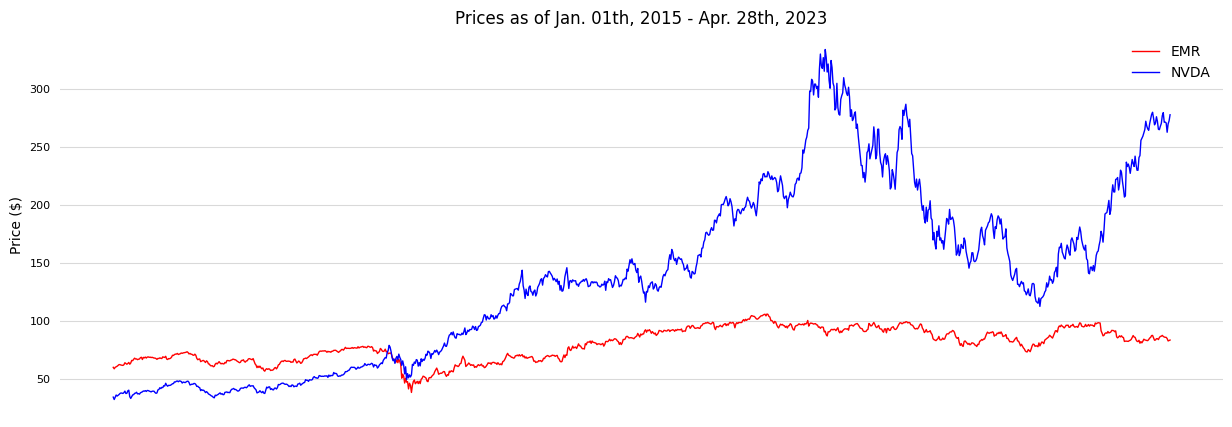

In [9]:
# Plotting Y and X.
sns.lineplot(data=Y, color='r', label=f'{y}')
sns.lineplot(data=X, color='b', label=f'{x}')
plt.xticks([])
plt.xlabel('')
plt.title(f'Prices as of {s} - {e}')
plt.ylabel('Price ($)')
plt.legend();

Below we set the rolling regression and moving average windows and run the regression. Note that signals are generated based on lagged regression coefficients (40 days) and moving average (40 days), resulting in an 80-day lag in our trading logic - trades can only begin after this amount of time. Optimizing the windows can be done using cross-validation, but it's beyond this paper's scope.

In [10]:
# Defining our regression window and moving average window
window = 40
ma_window = 40

# Conducting our rolling linear regression
rolling_regression = RollingOLS(Y, sm.add_constant(X), window=window).fit()

In [11]:
# Reformatting our parameters dataframe into a series.
B = rolling_regression.params.drop(columns='const')[f'{x}']

# Computing the linear combination of the price series.
C = Y - B*X
C.name = f'{y,x}'

('EMR', 'NVDA') is likely not stationary


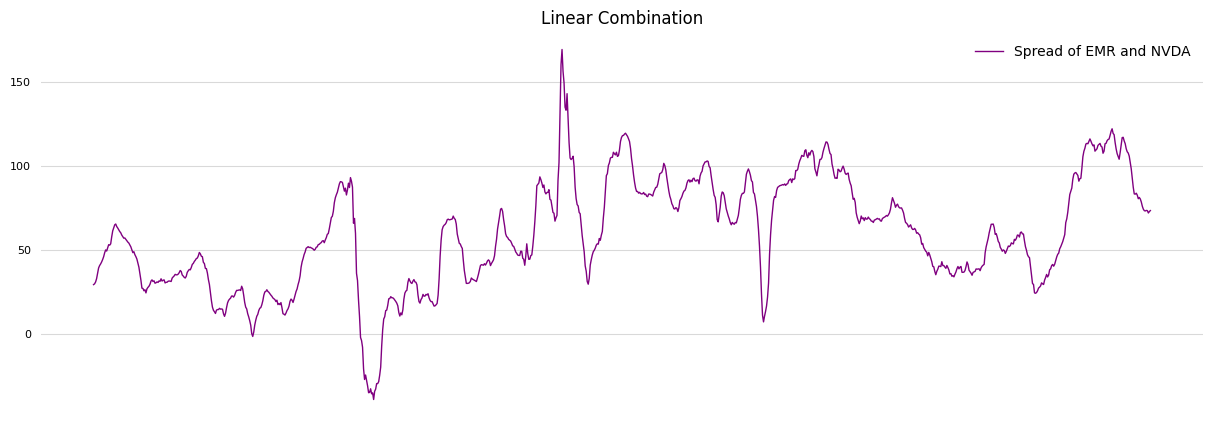

In [12]:
# Plotting the linear combination.
sns.lineplot(data=C, color='purple', label=f'Spread of {y} and {x}')
plt.title(f'Linear Combination')
plt.xticks([])
plt.xlabel('')
plt.ylabel('')
print(q.check_stationarity(C.dropna()))

In [13]:
# Computing the moving average and rolling standard deviation of C.
C_MA = C.rolling(window=ma_window).mean()
C_STD = C.rolling(window=ma_window).std()

# Computing our Z-Score.
Z = (C - C_MA) / C_STD
Z.name = f'{y,x} Z Score'

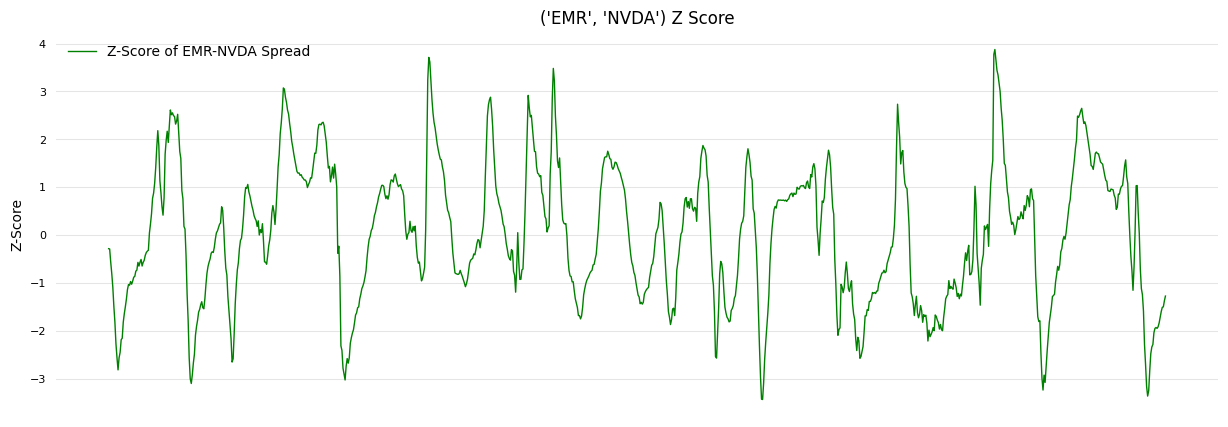

In [14]:
# Plotting the Z-Score.
sns.lineplot(data=Z, color='green', label=f'Z-Score of {y}-{x} Spread')
plt.xticks([])
plt.xlabel('')
plt.ylabel('Z-Score')
plt.grid(which='both', color='black', alpha=.1)
plt.title(Z.name);

#### Pairs Trading Logic

Below I define our pairs trading logic. As mentioned before, our trading signals are generated as follows:

Longs
- Enter long (buy `Y`, short `X`) - when `Z` reaches or moves below -`K`.
- Exit long (sell `Y`, repurchase `X`) when `Z` reverts to 0.<br>

Shorts
- Enter short (short `Y`, buy `X`) -  when `Z` reaches or moves beyond +`K`.
- Exit short (repurchase `Y`, sell `X`) when `Z` reverts to 0.

In our case, K=1.

In [15]:
# Defining our trading logic as a function
def pairs_trade(Z, K=1):
    # Position tracker variable
    position = None
    # Trade dates
    long_dates = []
    short_dates = []
    exit_long_dates = []
    exit_short_dates = []   
    # Iterate through the rows
    for i in range(len(Z)):
        # Variables to make logic more readable
        z_score = Z.iloc[i]
        date = Z.index[i]
        # If not in position and the z-score moves beyond k, enter short
        if position is None and z_score > K:
            position = 'short'
            short_dates.append(date)
         # If not in position and the z-score moves below k, enter long
        if position is None and z_score < -K:
            position = 'long'
            long_dates.append(date)
        # If currently in a short position and the z-score reverts to zero, exit short
        if position == 'short' and z_score <= 0:
            position = None
            exit_short_dates.append(date)
        # If currently in a long position and the z-score reverts to zero, exit long
        if position == 'long' and z_score >= 0:
            position = None
            exit_long_dates.append(date)
    # Return the corresponding dates, which will then be used to find the corresponding prices
    return long_dates, short_dates, exit_long_dates, exit_short_dates

# Calling our pairs trade function and storing the dates
ENTLONG_D, ENTSHORT_D, EXTLONG_D, EXTSHORT_D = pairs_trade(Z)

The `pairs_trade` function only locates the dates at which our signals were generated, so we need to locate those dates on the X and Y series to determine our exact short and long prices. Remember that `short_dates` contain dates where Y is shorted and X is longed, andnd vice versa for `long_dates`.

In [16]:
# Retrieving prices from longing and shorting Y and the corresponding exit dates
ENTLONGY_P, EXTLONGY_P = Y.loc[ENTLONG_D], Y.loc[EXTLONG_D]
ENTSHORTY_P, EXTSHORTY_P = Y.loc[ENTSHORT_D], Y.loc[EXTSHORT_D]

# Retrieving prices from longing and shorting X and the corresponding exit dates
ENTLONGX_P, EXTLONGX_P = X.loc[ENTSHORT_D], X.loc[EXTSHORT_D]
ENTSHORTX_P, EXTSHORTX_P = X.loc[ENTLONG_D], X.loc[EXTLONG_D]

# Computing percent profit per trade
LONGY_RS, SHORTY_RS = q.percent_profits(ENTLONGY_P, EXTLONGY_P), q.percent_profits(ENTSHORTY_P, EXTSHORTY_P)
LONGX_RS, SHORTX_RS = q.percent_profits(ENTLONGX_P, EXTLONGX_P), q.percent_profits(ENTSHORTX_P, EXTSHORTX_P)

# Profits for Y and X trades
Y_R = np.sum(LONGY_RS) + np.sum(SHORTY_RS)
X_R = np.sum(LONGX_RS) + np.sum(SHORTX_RS)

# Grand total profits
TOT_R = Y_R + X_R

Now that we've computed our total return from the trade, we can compare its returns against a few benchmarks:
- Benchmark 1: Only longing stock Y and shorting stock X for the given time frame.
- Benchmark 2: Buying and holding (or longing) both stocks.
- Benchmark 3: The return of buying and holding the S&P 500.

Ideally, considering our trading strategy involves multiple trades, it should outperform all three benchmarks, or else we take on more risk and more costs for a strategy that underperforms against simpler alternatives.

In [17]:
# Computing returns from the three benchmarks.
start_of_trading, end_of_trading = C_MA.first_valid_index(), C_MA.index.max() 
trades = len(ENTLONG_D) or len(ENTSHORT_D)
num_days = q.get_holding_period(start_of_trading, end_of_trading)
LYSX_R = q.benchmark_return(start_of_trading, end_of_trading, X, Y)
LBOTH_R = q.benchmark_return(start_of_trading, end_of_trading, X, Y, benchmark = 'buy hold both')
MKT_R = q.benchmark_return(start_of_trading, end_of_trading, X, Y, benchmark='S&P 500')

In [18]:
# Printing the summary.
print(f'FROM {start_of_trading} TO {end_of_trading}')
print(f'Number of trades: {trades} in {num_days} days')
print(f'Total return from trading pair ({Y.name}-{X.name}) {TOT_R*100:,.2f}%')
print('-'*75)
print(f'Total return from longing {Y.name} and shorting {X.name}: {LYSX_R*100:,.2f}%')
print(f'Total return from longing both {X.name} and {Y.name}: {LBOTH_R*100:,.2f}%')
print(f'Total return from buying and holding S&P 500 index: {MKT_R*100:,.2f}%')

FROM 2019-04-25 TO 2023-04-28
Number of trades: 17 in 1464 days
Total return from trading pair (EMR-NVDA) 162.12%
---------------------------------------------------------------------------
Total return from longing EMR and shorting NVDA: -66.35%
Total return from longing both NVDA and EMR: 510.65%
Total return from buying and holding S&P 500 index: 42.42%


Computing the total return of the strategy and comparing it to benchmarks shows us where it stands relative to other means of investing or trading, but we should also examine its risk-adjusted return. This can be seen through the strategy's Sharpe Ratio covered below.

---

## Sharpe Ratio

Using the `risk_free` and `trades_stats` functions from `quantfuncs.py` allows us to compute the risk-free rate of return, which we can then use to compute the Sharpe Ratio of the investment strategy based on the average excess returns per trade and the standard deviation of all the excess returns.

$$\text{Sharpe Ratio} = \frac{\bar{R}_{excess}}{\sigma_{R_{excess}}}$$
$$\text{where}$$
$$\bar{R}_{excess} = \sum_{i=1}^{n}\frac{1}{n}({R}_{i} - R_{riskfree}),\quad i = \text{each trade} \quad\& \quad n = \text{total trades executed}$$

In [19]:
# Compute the risk free rate and sharpes.
risk_free_rate = q.risk_free(start_of_trading, end_of_trading)

long, long_sharpe = q.trades_stats(
    ENTLONGY_P, ENTLONGX_P, EXTLONGY_P, EXTLONGX_P, LONGY_RS, LONGX_RS, risk_free_rate, type='long', Y=Y, X=X
)

short, short_sharpe = q.trades_stats(
    ENTSHORTY_P, ENTSHORTX_P, EXTSHORTY_P, EXTSHORTX_P, SHORTY_RS, SHORTX_RS, risk_free_rate, type='short', Y=Y, X=X
)

pairs_trade_sharpe = np.mean(long_sharpe + short_sharpe)

In [20]:
# Print the Sharpe Ratio.
print(f'Sharpe Ratio of Pairs Trading {Y.name}-{X.name}: {pairs_trade_sharpe:,.2f}')

Sharpe Ratio of Pairs Trading EMR-NVDA: 0.44


A small Sharpe Ratio for our strategy implies that its risk-adjusted performance is relatively low. Since the Sharpe Ratio measures the performance of our strategy compared to a risk-free asset like Treasury bills, a small Sharpe suggests that either the investment has low expected returns, high volatility, or both. Investors generally prefer a higher Sharpe Ratio, as it indicates that the investment is providing better returns for a given level of risk or that it has lower risk for a given level of return. 

However, a single Sharpe Ratio is not descriptive beyond the comparison against a risk-free asset, and comparing multiple Sharpe Ratios against each other can help shed light on which stock pair the strategy gives us the most risk-adjusted return. To do this, we have to run the above analysis on a basket of stocks, to give us a more comprehensive overview of the pairs trading strategy at large.

---

## Pairs Trading the Basket

In [21]:
# Basket trading.
basket_returns, _, basket_sharpes = q.pairs_trade_basket(cointegrated_stocks, out_sample_prices)

In [22]:
# Summarizing the returns and sharpes.
q.summarize_basket_trades(basket_sharpes, basket_returns).drop(columns='Rank')

,Sharpe Ratio,% Return
Pair,,
"(AMGN, MSFT)",0.964117,135.473754
"(TSLA, AXP)",0.886590,454.775946
"(AVB, INTC)",-0.418803,-86.230436
"(SRE, DLR)",-0.289485,-88.306629
Mean,0.236983,80.963539
Median,0.226036,64.680165


#### Sharpe Ratios from the Basket

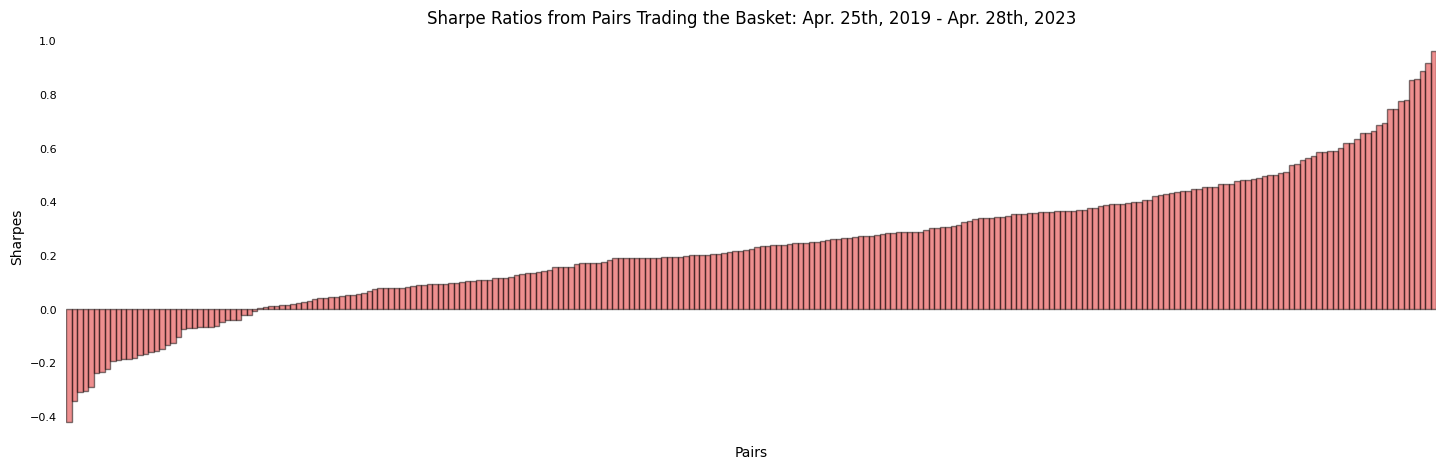

In [25]:
# Formatting dates for plot titles.
s = datetime.strptime(start_of_trading, '%Y-%m-%d').strftime('%b. %dth, %Y')
e = datetime.strptime(end_of_trading, '%Y-%m-%d').strftime('%b. %dth, %Y')

# Sharpe Ratios of trading the basket.
sharpes_barchart_title = f'Sharpe Ratios from Pairs Trading the Basket: {s} - {e}'
q.basket_bar_chart(basket_sharpes, title=sharpes_barchart_title, ylabel='Sharpes')

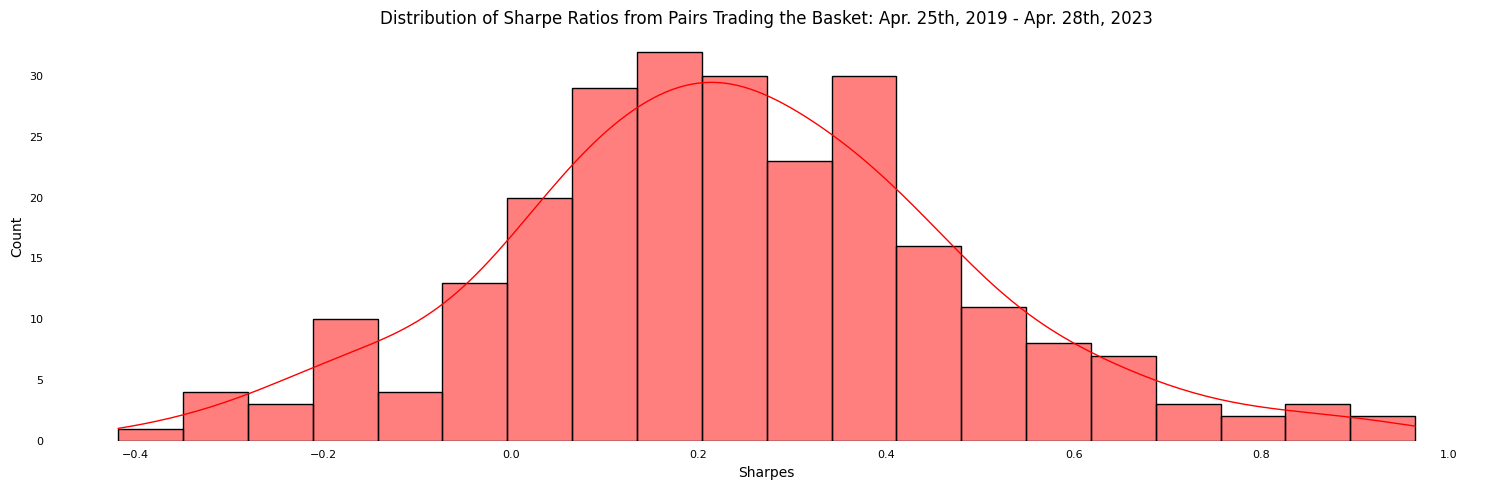

In [26]:
# Distribution of Sharpe Ratios from trading the basket.
sharpes_hist_title = f'Distribution of Sharpe Ratios from Pairs Trading the Basket: {s} - {e}'
q.basket_histogram(basket_sharpes, title=sharpes_hist_title, xlabel='Sharpes')

#### Returns from the Basket

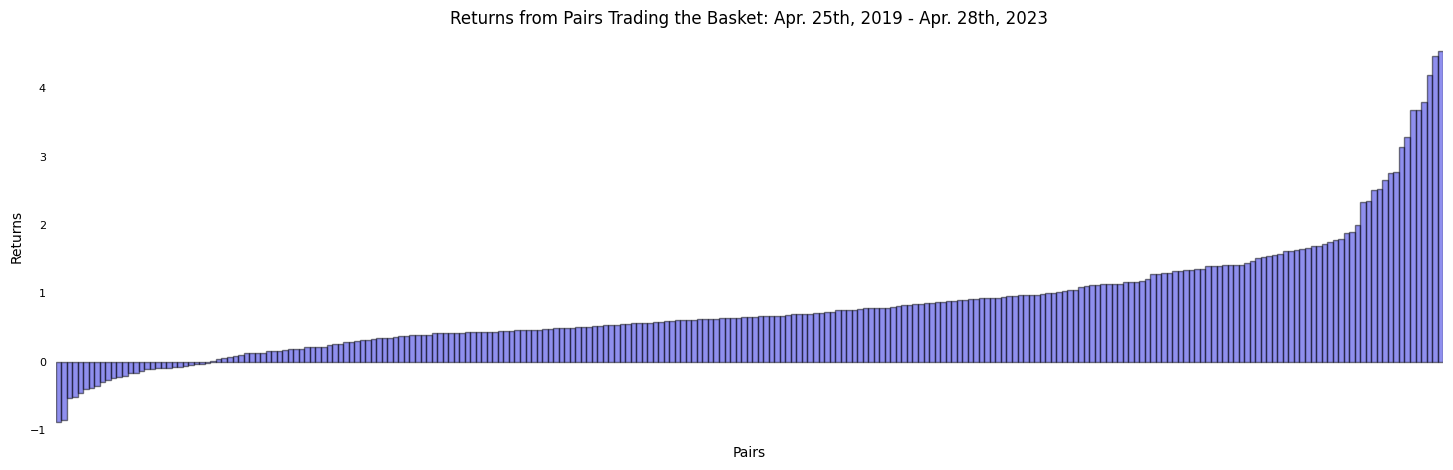

In [27]:
# Returns from trading the basket.
returns_barchart_title = f'Returns from Pairs Trading the Basket: {s} - {e}'
q.basket_bar_chart(basket_returns, title=returns_barchart_title, ylabel='Returns', color='b')

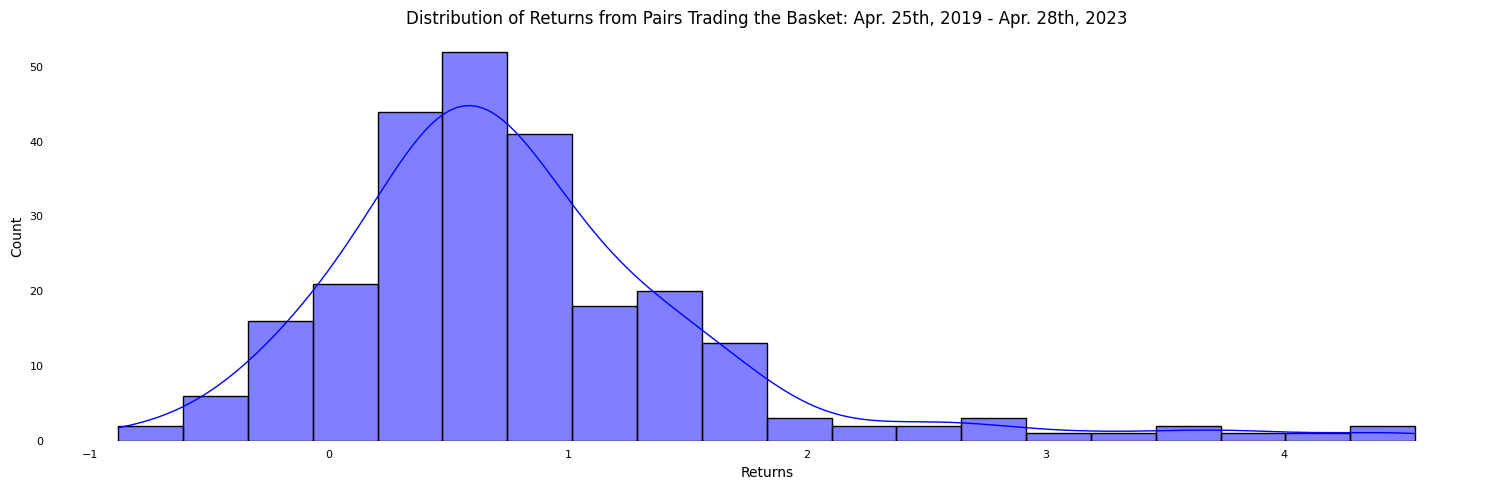

In [28]:
# Distribution of returns from trading the basket.
returns_hist_title = f'Distribution of Returns from Pairs Trading the Basket: {s} - {e}'
q.basket_histogram(basket_returns, title=returns_hist_title, xlabel='Returns', color='b')

---

## Conclusion

In conclusion, our backtesting results show that pairs trading based on historical cointegration can yield positive returns. However, it is crucial to consider fees, transaction costs, and taxes, as they can significantly impact the realized returns in practice. In this backtest, we simplified the analysis by not considering these costs, but it is essential to account for them in real-world scenarios to avoid working with inaccurate representations of reality.

Another concern is the relatively low Sharpe ratios obtained from the backtest, suggesting that the risk-return profiles for most of the pairs traded were not ideal. When considering the additional costs mentioned earlier, the actual Sharpe ratios would likely be even lower.

Despite the limitations of this backtest, the results still indicate that trading pairs based on their historical cointegration is a valid approach. Cointegration implies a long-term relationship between two assets, where deviations from their equilibrium are expected to revert over time. By exploiting this mean-reverting behavior, it is possible to develop profitable trading strategies. However, it is important to refine the model, account for all costs, and consider the risk-return profile before implementing such a strategy in a live trading environment.

---

## Appendix

In this section I'll explain the main imports from `quantfuncs.py` (alias `q`).

**For the sake of concision I will omit computational functions as the base logic for those are covered in the main section.*

1. `universe` - The universe dictionary is a representation of various sectors in the stock market, with each sector containing a list of stock tickers and their corresponding ETFs or indices. This dictionary serves as a basis for our analysis, enabling us to access and analyze stocks and their sector-specific benchmarks conveniently. The dictionary is organized into key-value pairs, where each key represents a sector, and the corresponding value is a nested dictionary containing two keys: 'tickers' and 'indices'. The 'tickers' key maps to a list of 10 prominent stock tickers within that sector, while the 'indices' key maps to a list of 3 representative ETFs or indices for the sector. `call_universe()` calls the `universe` dictionary as a dataframe.

In [ ]:
universe = {
    'Technology': {
        'tickers': ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'MET', 'TSLA', 'NVDA', 'INTC', 'CSCO', 'ADBE'],
        'indices': ['XLK', 'VGT', 'FDN']
    },
    'Financial': {
        'tickers': ['JPM', 'BAC', 'V', 'MA', 'GS', 'MS', 'AXP', 'WFC', 'C', 'USB'],
        'indices': ['XLF', 'VFH', 'KBE']
    },
    'Healthcare': {
        'tickers': ['JNJ', 'UNH', 'PFE', 'MRK', 'ABT', 'MDT', 'LLY', 'AMGN', 'GILD', 'VRTX'],
        'indices': ['XLV', 'VHT', 'IBB']
    },
    'Consumer': {
        'tickers': ['WMT', 'KO', 'PEP', 'PG', 'MCD', 'NKE', 'SBUX', 'MMM', 'CL', 'KMB'],
        'indices': ['XLY', 'XLP', 'VCR']
    },
    'Energy': {
        'tickers': ['XOM', 'CVX', 'COP', 'EOG', 'PSX', 'MPC', 'VLO', 'OXY', 'HES', 'PXD'],
        'indices': ['XLE', 'VDE', 'FENY']
    },
    'Industrials': {
        'tickers': ['GE', 'HON', 'UNP', 'MMM', 'BA', 'CAT', 'DE', 'CSX', 'EMR', 'ETN'],
        'indices': ['XLI', 'VIS', 'ITA']
    },
    'Utilities': {
        'tickers': ['NEE', 'DUK', 'SO', 'D', 'EXC', 'AEP', 'SRE', 'XEL', 'WEC', 'PEG'],
        'indices': ['XLU', 'VPU', 'IDU']
    },
    'Real Estate': {
        'tickers': ['SPG', 'PLD', 'EQIX', 'EQR', 'AVB', 'PSA', 'VTR', 'WELL', 'CCI', 'DLR'],
        'indices': ['XLRE', 'VNQ', 'IYR']
    },
    'Materials': {
        'tickers': ['LIN', 'APD', 'ECL', 'PPG', 'NEM', 'IFF', 'SHW', 'LYB', 'ALB', 'CE'],
        'indices': ['XLB', 'VAW', 'RTM']
    }
}

In [ ]:
def call_universe(universe=universe):
    ticker_data = {
        sector: universe[sector]['tickers'] + universe[sector]['indices']  for sector in universe
    }
    df = pd.DataFrame.from_dict(ticker_data, orient='index').T
    df.index.name = '#'
    df.index += 1
    return df

2. `fetch_and_split_price_data` - This function uses two additional functions, `get_pricing` and `get_price_data`. The base function, `get_pricing` uses the [Financial Modelling Prep API](https://site.financialmodelingprep.com/developer/docs/) to fetch historical ticker data. These work together to use multi-threading to fetch and split price data for a list of stock tickers. The `get_price_data` function fetches price data for a given stock ticker between a specified start and end date. It then splits the data into two parts: in-sample data (from `start` to `insamp_end`) and out-of-sample data (from `insamp_end` to `end`). It stores the fetched data in the dictionaries in_sample_prices and out_sample_prices. The `fetch_and_split_price_data` function takes a list of tickers, a start date, an end date, and an in-sample end date. It initializes two dictionaries, `in_sample_prices` and `out_sample_prices`, and a threading lock. It then creates a new thread for each ticker in the list and starts the thread, calling the `get_price_data` function with the specified parameters. Finally, it waits for all threads to finish using `t.join()` and returns the two dictionaries containing the fetched in-sample and out-of-sample price data. This implementation uses multi-threading to fetch and split price data for multiple stock tickers simultaneously, which can save a significant amount of time compared to fetching the data sequentially. To have all these work you need to import `requests` and `threading`.

In [ ]:
import requests
import threading

In [ ]:
def get_pricing(
        stock_symbol, API_KEY='xxxx', start=None, end=None, period=None, column='Close'
):
    base_url = "https://financialmodelingprep.com/api/v3/historical-price-full/"
    if period == 'max':
        api_url = f"{base_url}{stock_symbol}?apikey={API_KEY}&serietype=line"
    else:
        api_url = f"{base_url}{stock_symbol}?from={start}&to={end}&apikey={API_KEY}"
    response = requests.get(api_url)
    df = pd.DataFrame(response.json()['historical'])
    df.rename(
        columns={
            'date':'Date','close':'Close','open':'Open','high':'High','low':'Low'
        }, inplace=True
    )
    df.set_index('Date', inplace=True)
    
    if response.status_code == 200:
        return df[column].iloc[::-1]
    else:
        print(f"Error: {response.status_code}")
        return None

In [ ]:
def get_price_data(ticker, start, end, insamp_end, in_sample_prices, out_sample_prices, lock):
    data = get_pricing(ticker, start=start, end=end)
    in_sample = data.loc[start:insamp_end]
    out_sample = data.loc[insamp_end:end]
    with lock:
        in_sample_prices[ticker] = in_sample
        out_sample_prices[ticker] = out_sample

In [ ]:
def fetch_and_split_price_data(tickers, start, end, insamp_end):
    in_sample_prices = {}
    out_sample_prices = {}
    lock = threading.Lock()
    threads = []
    for ticker in tickers:
        t = threading.Thread(
            target=get_price_data, args=(
            ticker, start, end, insamp_end, in_sample_prices, out_sample_prices, lock
            )
        )
        t.start()
        threads.append(t)
    for t in threads:
        t.join()
    return in_sample_prices, out_sample_prices

3. `find_cointegrated_pairs` - This function combines `single_pair_cointegration` and `find_cointegrated_pairs`, which are used to identify cointegrated pairs of stocks from given price data. The `single_pair_cointegration` function takes a pair of stock tickers, price data, and a significance level as inputs. It checks if the lengths of the price data for both stocks are equal and then calculates the cointegration test statistic, p-value, and critical values using the `coint` (augmented Engle-Granger test from `statsmodels.tsa.stattools`) function. If the p-value is below the specified significance level, the function returns the pair; otherwise, it returns None. The find_cointegrated_pairs function takes price data, a significance level (defaulting to 0.01), and the maximum number of worker threads (defaulting to 90) as inputs. It initializes an empty list cointegrated_pairs and a threading lock. The function then generates a list of all possible combinations of stock ticker pairs. Using the `ThreadPoolExecutor` from `concurrent.futures`, it creates and submits futures for each ticker pair to perform the cointegration test concurrently. The function waits for all futures to complete, and if a future returns a cointegrated pair, it appends the pair to the cointegrated_pairs list. The function sorts the cointegrated pairs based on their p-values and returns the sorted list. This implementation identifies cointegrated pairs of stocks by leveraging multi-threading to perform the cointegration test on multiple stock pairs simultaneously.

In [ ]:
from concurrent.futures import ThreadPoolExecutor, wait
from statsmodels.tsa.stattools import coint

In [ ]:
def single_pair_cointegration(pair, price_data, sig_level):
    ticker1, ticker2 = pair
    S1 = price_data[ticker1]
    S2 = price_data[ticker2]
    if len(S1.index) == len(S2.index):
        t, p, c = coint(S1, S2)
    else:
        return None
    if p < sig_level:
        return pair
    else:
        return None

In [ ]:
def find_cointegrated_pairs(price_data, sig_lvl=0.01, max_workers=90):
    cointegrated_pairs = []
    lock = threading.Lock()
    ticker_combs = list(combinations(list(price_data.keys()), r=2))
    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        futures = [
            executor.submit(
            single_pair_cointegration, pair, price_data, sig_lvl
            ) for pair in ticker_combs
        ]
        for future in wait(futures).done:
            pair = future.result()
            with lock:
                if pair is not None:
                    cointegrated_pairs.append(pair)
    cointegrated_pairs = sorted(cointegrated_pairs, key=lambda x: x[1])
    return cointegrated_pairs

4. `pairs_trade_basket` - Uses the `pairs_trade` function defined in the main analysis, with an additional function `process_pair` to work with multithreading. `pairs_trade` takes a Z-score series and a threshold value (K) as inputs. It finds the entry and exit points for long and short trades based on the threshold value. It returns the corresponding dates for entering and exiting long and short positions. `process_pair` processes a pair of stocks, calculating rolling regression parameters, constructing a cointegrated time series, and applying the pairs trading strategy using the pairs_trade function. It returns the pair, total return, long and short trade statistics, and the Sharpe ratio for the pair. Finally, `pairs_trade_basket` takes a list of cointegrated pairs and the out-of-sample price data as inputs. It processes each pair using the process_pair function and stores the results in dictionaries for total returns, trade statistics, and Sharpe ratios. It returns these dictionaries for further analysis.

In [ ]:
def process_pair(pair, out_sample_prices, window=40, ma_window=40, K=1):
    y = pair[0]
    x = pair[1]
    Y = out_sample_prices[y]
    X = out_sample_prices[x]
    Y.name = y
    X.name = x
    rolling_regression = RollingOLS(Y, sm.add_constant(X), window=window).fit()
    params = rolling_regression.params.drop(columns='const')
    params.rename(columns={f'{x}': f'B_{x}'}, inplace=True)
    B = params[f'B_{x}']
    C = Y - B*X
    C_MA = C.rolling(window=ma_window).mean()
    C_STD = C.rolling(window=ma_window).std()
    Z = (C - C_MA) / C_STD
    ENTLONG_D, ENTSHORT_D, EXTLONG_D, EXTSHORT_D = pairs_trade(Z, K=K)
    ENTLONGY_P, EXTLONGY_P = Y.loc[ENTLONG_D], Y.loc[EXTLONG_D]
    ENTSHORTY_P, EXTSHORTY_P = Y.loc[ENTSHORT_D], Y.loc[EXTSHORT_D]
    ENTLONGX_P, EXTLONGX_P = X.loc[ENTSHORT_D], X.loc[EXTSHORT_D]
    ENTSHORTX_P, EXTSHORTX_P = X.loc[ENTLONG_D], X.loc[EXTLONG_D]
    LONGY_RS, SHORTY_RS = percent_profits(ENTLONGY_P, EXTLONGY_P), percent_profits(ENTSHORTY_P, EXTSHORTY_P)
    LONGX_RS, SHORTX_RS = percent_profits(ENTLONGX_P, EXTLONGX_P), percent_profits(ENTSHORTX_P, EXTSHORTX_P)
    Y_R = np.sum(LONGY_RS) + np.sum(SHORTY_RS)
    X_R = np.sum(LONGX_RS) + np.sum(SHORTX_RS)
    TOT_R = Y_R + X_R
    start_of_trading, end_of_trading = C_MA.first_valid_index(), C_MA.index.max() 
    risk_free_rate = risk_free(start_of_trading, end_of_trading)
    long, long_sharpe = trades_stats(
        ENTLONGY_P, ENTLONGX_P, EXTLONGY_P, EXTLONGX_P, LONGY_RS, LONGX_RS, 
        risk_free_rate, type='long', Y=Y, X=X
    )
    short, short_sharpe = trades_stats(
        ENTSHORTY_P, ENTSHORTX_P, EXTSHORTY_P, EXTSHORTX_P, SHORTY_RS, SHORTX_RS, 
        risk_free_rate, type='short', Y=Y, X=X
    )
    pairs_trade_sharpe = np.mean(long_sharpe + short_sharpe)    
    return (pair, TOT_R, long, short, pairs_trade_sharpe)

In [ ]:
def pairs_trade_basket(cointegrated_pairs, out_sample_prices, window=40, ma_window=40, K=1, max_workers=90):
    TOTAL_RETURNS = {}
    TRADES_STATS = {}
    SHARPES = {}
    lock = threading.Lock()
    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        futures = [
            executor.submit(
            process_pair, pair, out_sample_prices, window, ma_window, K
            ) for pair in cointegrated_pairs if len(
            out_sample_prices[pair[0]]
            ) == len(
            out_sample_prices[pair[1]]
            )
        ]
        for future in wait(futures).done:
            pair, TOT_R, long, short, pairs_trade_sharpe = future.result()
            y, x = pair
            with lock:
                TOTAL_RETURNS[y, x] = TOT_R
                TRADES_STATS[y, x] = {'long': long, 'short': short}
                SHARPES[y, x] = pairs_trade_sharpe
    return TOTAL_RETURNS, TRADES_STATS, SHARPES